In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from sqlalchemy import create_engine, inspect, func

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
inspector= inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [6]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [7]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine, reflect=True)

In [8]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
recent_date_set = session.query(measurement.date).order_by(measurement.date).first()
print(f"Earliest:{recent_date_set[0]}")
last_date_set = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(f"latest:{last_date_set[0]}")

Earliest:2010-01-01
latest:2017-08-23


In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
latest_date = dt.datetime.strptime(last_date_set[0], '%Y-%m-%d')
last_year_date = dt.date(latest_date.year -1, latest_date.month, latest_date.day)
last_year_date
# Perform a query to retrieve the data and precipitation scores
sel = [measurement.date, measurement.prcp]
precip_query = session.query(*sel). filter(measurement.date >= last_year_date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
precipitation = pd.DataFrame(precip_query, columns=["Date", "Precipitation"])
precipitation = precipitation.dropna(how='any')
precipitation =precipitation.sort_values(["Date"], ascending = True)
precipitation =precipitation.set_index("Date")
print(precipitation)

            Precipitation
Date                     
2016-08-23           0.00
2016-08-23           0.02
2016-08-23           0.05
2016-08-23           0.70
2016-08-23           0.15
...                   ...
2017-08-22           0.50
2017-08-23           0.00
2017-08-23           0.08
2017-08-23           0.00
2017-08-23           0.45

[2021 rows x 1 columns]


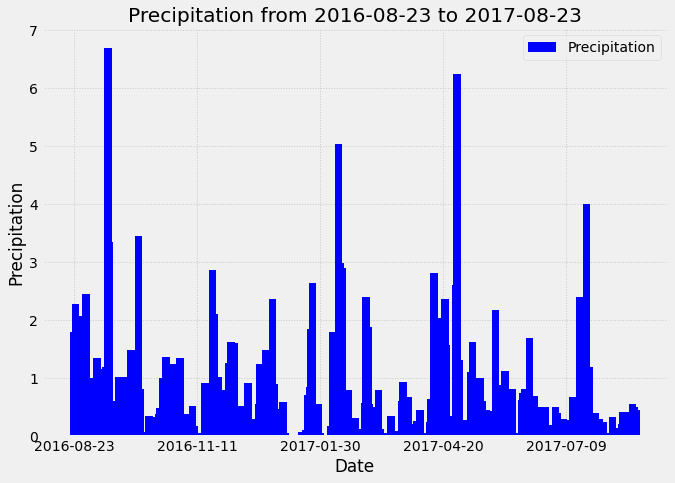

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
x = precipitation.index.tolist()
y = precipitation['Precipitation'].tolist()

plt.figure(figsize=(10,7))
plt.bar(x,y,width = 5 ,color='b', align="center",label='Precipitation')
plt.tick_params(
 # changes apply to the x-axis
    axis='x', 
 # both major and minor ticks are affected
    which='both', 
 # ticks along the bottom edge are on
    bottom=True,   
# ticks along the top edge are off
    top=False,
# labels along the bottom edge are on
    labelbottom=True)
# fixes x-axis tick issues
major_ticks = np.arange(0,400,80)
plt.xticks(major_ticks)

plt.title(f"Precipitation from {last_year_date} to {last_date_set[0]}")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.grid(which='major', axis='both', linestyle=':')
plt.legend()
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number stations in the dataset
session.query(station.id).count()

9

In [16]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
sel = [measurement.station, func.count(measurement.id)]
active_stations = session.query(*sel).\
    group_by(measurement.station).\
    order_by(func.count(measurement.id).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)]
most_active_station = session.query(*sel).\
    group_by(measurement.station).\
    order_by(func.count(measurement.id).desc()).first()
most_active_station

(54.0, 85.0, 71.66378066378067)

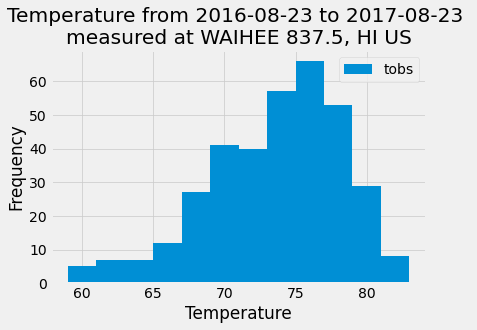

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
queryresult = session.query(measurement.tobs).\
    filter(measurement.station == active_stations[0][0]).\
    filter(measurement.date >= last_year_date).all()
temperatures = list(np.ravel(queryresult))

sel = [station.station,station.name,station.latitude,station.longitude,station.elevation]
queryresult = session.query(*sel).all()
stations_desc = pd.DataFrame(queryresult, columns=['Station','Name','Latitude','Longitude','Elevation'])

stationname = stations_desc.loc[stations_desc["Station"] == active_stations[0][0],"Name"].tolist()[0]

plt.hist(temperatures, bins=12,rwidth=1.0,label='tobs')
plt.grid(axis='both', alpha=0.75)
plt.ylabel('Frequency')
plt.xlabel('Temperature')
# \n brings everything to the right of it down a row so the title isnt too long
plt.title(f"Temperature from {last_year_date} to {last_date_set[0]} \nmeasured at {stationname}")
plt.legend()

# Close session

In [19]:
# Close Session
session.close()